# Studienprojekt 1 - Deep Reinforcement Learning Agent zum Schutz von E-Commerce Webanwendungen

In diesem Notebook wird ein Deep Q Network mit TF-Agents trainiert, um mögliche Kontoübernahmen (z.B. Bruteforce) zu erkennen.  
Zur Entwicklung wurde das Tutorial/Beispiel "Train a Deep Q Network with TF-Agents" von Tensorflow als Grundlage genutzt.  

Lizenz am Ende. Original auf: [TensorFlow.org](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) oder [GitHub](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb)

## Setup

In [167]:
%pip install tf-agents[reverb]==0.19.0
%pip install tf_keras==2.15.1


[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [168]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import reverb
import datetime

import tensorflow as tf
from tf_agents import trajectories as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import array_spec
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [170]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

## Paramter

In [171]:
num_iterations = 480000 # 20.000 ~ 3min, 60.000 ~ 10min, 200.000 ~ 38min

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000


In [172]:
file_name = "/tf/plots/DRL_V2_" + current_time + ".txt"

parameters = f"""
num_iterations = {num_iterations}

initial_collect_steps = {initial_collect_steps}
collect_steps_per_iteration = {collect_steps_per_iteration}
replay_buffer_max_length = {replay_buffer_max_length}

batch_size = {batch_size}
learning_rate = {learning_rate}
log_interval = {log_interval}

num_eval_episodes = {num_eval_episodes}
eval_interval = {eval_interval}
"""

# Speichere die Parameter in der Datei
with open(file_name, "w") as file:
    file.write(parameters)

print(f"Parameter wurden in {file_name} gespeichert.")

Parameter wurden in /tf/plots/DRL_V2_20240722_173942.txt gespeichert.


## Umgebung

Beim Reinforcement Learning (RL) stellt eine Umgebung die zu lösende Aufgabe oder das Problem dar. 


In [173]:
class LoginEnv(py_environment.PyEnvironment):
    def __init__(self):

        # Zustandseigenschaften: Richtiges Passwort (boolean), Zeit zwischen Loginversuchen (date), Falsches Passwort Zähler (int), letzte Aktion (int)
        self._observation_spec = array_spec.BoundedArraySpec(
                                shape=(4,), dtype=np.int32, minimum=0, name='observation')

        # Aktionen: 0 = Nicht sperren, 1 = 30s sperren, 2 = 1m sperren, 3 = 3min sperren, 4 = Dauerhaft sperren
        self._action_spec = array_spec.BoundedArraySpec(
                                shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')

        # Interne Zustandsvariablen initialisieren
        self._state = np.array([0, 0, 0, 0], dtype=np.int32)
        self._episode_ended = False
        self._current_time_step = None

    def _reset(self):
        self._state[0] = np.random.choice([0, 1])  # Richtiges Passwort: 0 oder 1 (1=true)
        self._state[1] = np.random.randint(0, 600)  # Zeit zwischen Loginversuchen

        # Falsches Passwort Zähler basierend auf der letzten Aktion setzen
        self._state[3] = np.random.randint(0, 4)
        if self._state[3] == 0:
            self._state[2] = np.random.randint(0, 3)
        elif self._state[3] == 1:
            self._state[2] = np.random.randint(4, 6)
        elif self._state[3] == 2:
            self._state[2] = np.random.randint(7, 9)
        else:
            self._state[2] = np.random.randint(10, 12)
        
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        print(f"Richtiges Passwort: {self._state[0]}, Zeit zwischen Loginversuchen: {self._state[1]} Sekunden, Falsches Passwort Zähler: {self._state[2]}, Letzte Aktion: {self._state[3]}")
        
        reward = 0
        if action == 0:  # Nicht sperren
            print("Aktion 0")
            if self._state[0] == 1 or (self._state[1] >= 2 and self._state[2] <= 3 and self._state[3] == 0): # Richtiges Passwort ODER: Mehr als 1s zwischen Loginversuchen und weniger als 4 falsche Passwörter und letzte Aktion war "Nicht Sperren"
                reward = 1
                self._episode_ended = True
            else:
                reward = -1
                self._episode_ended = True
        elif action == 1:  # 30s sperren
            print("Aktion 1")
            if self._state[0] == 1 or self._state[3] != 0: # Richtiges Passwort ODER: Letzte Aktion war nicht "Nicht Sperren"
                reward = -1
                self._episode_ended = True
            elif self._state[1] < 2 or (3 < self._state[2] <= 6): # Falsches Passwort UND: Weniger als 2s zwischen Loginversuchen oder 4-6 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 2:  # 1m sperren
            print("Aktion 2")
            if self._state[0] == 1 or self._state[3] != 1: # Richtiges Passwort ODER: Letzte Aktion war nicht "30s Sperren"
                reward = -1
                self._episode_ended = True
            elif self._state[1] < 2 or (6 < self._state[2] <= 9): # Falsches Passwort UND: Weniger als 2s zwischen Loginversuchen oder 7-9 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 3:  # 3min sperren
            print("Aktion 3")
            if self._state[0] == 1 or self._state[3] != 2: # Richtiges Passwort ODER: Letzte Aktion war nicht "1m Sperren"
                reward = -1
                self._episode_ended = True
            elif self._state[1] < 2 or (9 < self._state[2] <= 12): # Falsches Passwort UND: Weniger als 2s zwischen Loginversuchen oder 10-12 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 4:  # Dauerhaft sperren
            print("Aktion 4")
            if self._state[0] == 1 or self._state[3] != 3: # Richtiges Passwort ODER: Letzte Aktion war nicht "3min Sperren"
                reward = -1
                self._episode_ended = True
            elif self._state[1] < 2 or self._state[2] >= 13: # Falsches Passwort UND: Weniger als 2s zwischen Loginversuchen oder mehr als 12 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True

        if self._episode_ended:
            print("Episode beendet")
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            print("Episode nicht beendet")
            return ts.transition(np.array(self._state, dtype=np.int32), reward=0.0, discount=1.0)

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def set_state(self, state):
        """Set the internal state manually."""
        self._state = np.array(state, dtype=np.int32)
        self._episode_ended = False
        self._current_time_step = ts.restart(np.array(self._state, dtype=np.int32))


In der Regel werden zwei Umgebungen instanziiert: eine für das Training und eine für die Auswertung.

In [174]:
env = LoginEnv()
train_py_env = LoginEnv()
eval_py_env = LoginEnv()

Die Umgebung ist in reinem Python geschrieben. Sie wird mit Hilfe des `TFPyEnvironment` Wrappers in TensorFlow konvertiert.

Die API der ursprünglichen Umgebung verwendet Numpy-Arrays. Die `TFPyEnvironment` konvertiert diese in `Tensors`, um sie mit Tensorflow Agenten und Richtlinien kompatibel zu machen.

In [175]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

Der Algorithmus zur Lösung eines RL-Problems wird durch einen "Agenten" dargestellt. Der DQN-Agent kann in jeder Umgebung eingesetzt werden, die einen diskreten Aktionsraum hat.

Das Herzstück eines DQN-Agenten ist ein `QNetwork`, ein neuronales Netzmodell, das lernen kann, `QValues` (erwartete Erträge) für alle Aktionen vorherzusagen, wenn eine Beobachtung aus der Umgebung vorliegt.

Wir werden `tf_agents.networks.` verwenden, um ein `QNetwork` zu erstellen. Das Netzwerk besteht aus einer Folge von `tf.keras.layers.Dense`-Schichten, wobei die letzte Schicht einen Ausgang für jede mögliche Aktion hat.

In [176]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Verwenden Sie nun `tf_agents.agents.dqn.dqn_agent`, um einen `DqnAgent` zu instanziieren. Zusätzlich zur `time_step_spec`, `action_spec` und dem QNetwork benötigt der Agentenkonstruktor auch einen Optimierer (in diesem Fall `AdamOptimizer`), eine Verlustfunktion und einen ganzzahligen Schrittzähler.

In [177]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

Eine Policy definiert die Art und Weise, wie ein Agent in einer Umgebung agiert. Normalerweise besteht das Ziel des Verstärkungslernens darin, das zugrunde liegende Modell so lange zu trainieren, bis die Strategie das gewünschte Ergebnis liefert.

Agenten enthalten zwei Richtlinien:

- `agent.policy` - Die Hauptrichtlinie, die für die Auswertung und den Einsatz verwendet wird.
- `agent.collect_policy` - Eine zweite Richtlinie, die für die Datenerfassung verwendet wird.


In [178]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies können aber auch unabhängig von Agenten erstellt werden:

In [179]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

## Metriken and Auswertung

Die gebräuchlichste Kennzahl zur Bewertung einer Strategie ist die durchschnittliche Rendite. Die Rendite ist die Summe der Belohnungen, die bei der Ausführung einer Strategie in einer Umgebung für eine Episode erzielt werden. Es werden mehrere Episoden ausgeführt, so dass eine durchschnittliche Rendite entsteht.

Die folgende Funktion berechnet die durchschnittliche Rendite einer Richtlinie, wenn die Richtlinie, die Umgebung und eine Anzahl von Episoden gegeben sind.


In [180]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

## Wiederholungspuffer

Um den Überblick über die von der Umgebung gesammelten Daten zu behalten, werden wir [Reverb](https://deepmind.com/research/open-source/Reverb) verwenden, ein effizientes, erweiterbares und einfach zu verwendendes Wiedergabesystem von Deepmind. Es speichert Erfahrungsdaten, wenn wir Trajektorien sammeln und wird während des Trainings verbraucht.

Dieser Replay-Puffer wird mit Hilfe von Spezifikationen aufgebaut, die die zu speichernden Tensoren beschreiben und die vom Agenten mit agent.collect_data_spec erhalten werden können.


In [181]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpuxbkdmbx.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpuxbkdmbx
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41559


## Datensammlung

Nun wird die Zufallsrichtlinie in der Umgebung für einige Schritte ausgeführt und die Daten werden im Wiedergabepuffer aufgezeichnet.

Hier verwenden wir 'PyDriver', um die Erfahrungssammelschleife auszuführen. Mehr über den TF-Agententreiber erfahren Sie in dem [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [182]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 337 Sekunden, Falsches Passwort Zähler: 10, Letzte Aktion: 3
Aktion 1
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 510 Sekunden, Falsches Passwort Zähler: 11, Letzte Aktion: 3
Aktion 3
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 461 Sekunden, Falsches Passwort Zähler: 8, Letzte Aktion: 2
Aktion 4
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 593 Sekunden, Falsches Passwort Zähler: 1, Letzte Aktion: 0
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 340 Sekunden, Falsches Passwort Zähler: 4, Letzte Aktion: 1
Aktion 0
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 322 Sekunden, Falsches Passwort Zähler: 5, Letzte Aktion: 1
Aktion 0
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 131 Sekunden, Falsches Passwort Zähler: 0, Letzte Aktion: 0
Aktion 2
Episode beendet
Richtiges Passwort: 0, Zeit zwis

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([  1, 270,   2,   0], dtype=int32)}),
 ())

Der Agent benötigt Zugriff auf den Wiedergabepuffer. Dies geschieht durch die Erstellung einer iterierbaren Pipeline "tf.data.Dataset", die den Agenten mit Daten versorgt.

Jede Zeile des Wiedergabepuffers speichert nur einen einzigen Beobachtungsschritt. Da der DQN-Agent jedoch sowohl die aktuelle als auch die nächste Beobachtung benötigt, um den Verlust zu berechnen, nimmt die Datensatz-Pipeline für jedes Element im Stapel zwei benachbarte Zeilen auf (`num_steps=2`).

Dieser Datensatz wird auch durch parallele Aufrufe und den Vorabruf von Daten optimiert.

In [183]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.int32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [184]:
iterator = iter(dataset)
print(iterator)

## Agenten trainieren

Während der Trainingsschleife müssen zwei Dinge geschehen:

- Daten aus der Umgebung sammeln
- diese Daten verwenden, um das/die neuronale(n) Netz(e) des Agenten zu trainieren

In [185]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 583 Sekunden, Falsches Passwort Zähler: 5, Letzte Aktion: 1
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 557 Sekunden, Falsches Passwort Zähler: 11, Letzte Aktion: 3
Aktion 1
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 44 Sekunden, Falsches Passwort Zähler: 1, Letzte Aktion: 0
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 354 Sekunden, Falsches Passwort Zähler: 5, Letzte Aktion: 1
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 374 Sekunden, Falsches Passwort Zähler: 8, Letzte Aktion: 2
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 337 Sekunden, Falsches Passwort Zähler: 0, Letzte Aktion: 0
Aktion 1
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 354 Sekunden, Falsches Passwort Zähler: 5, Letzte Aktion: 1
Aktion 1
Episode beendet
Richtiges Passwort: 0, Zeit zwisch

## Save Checkpoint

In [186]:
checkpoint_dir = '/tf/checkpoints/'
checkpoint = tf.train.Checkpoint(agent=agent)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=None)

save_path = checkpoint.save(file_prefix=checkpoint_dir + "DRL_V2_" + current_time)
print(f'Checkpoint saved at {save_path}')

Checkpoint saved at /tf/checkpoints/DRL_V2_20240722_173942-1


## Visualisierung

Die Bibliothek `matplotlib.pyplot` wird verwendet, um darzustellen, wie sich die Strategie während des Trainings verbessert hat.

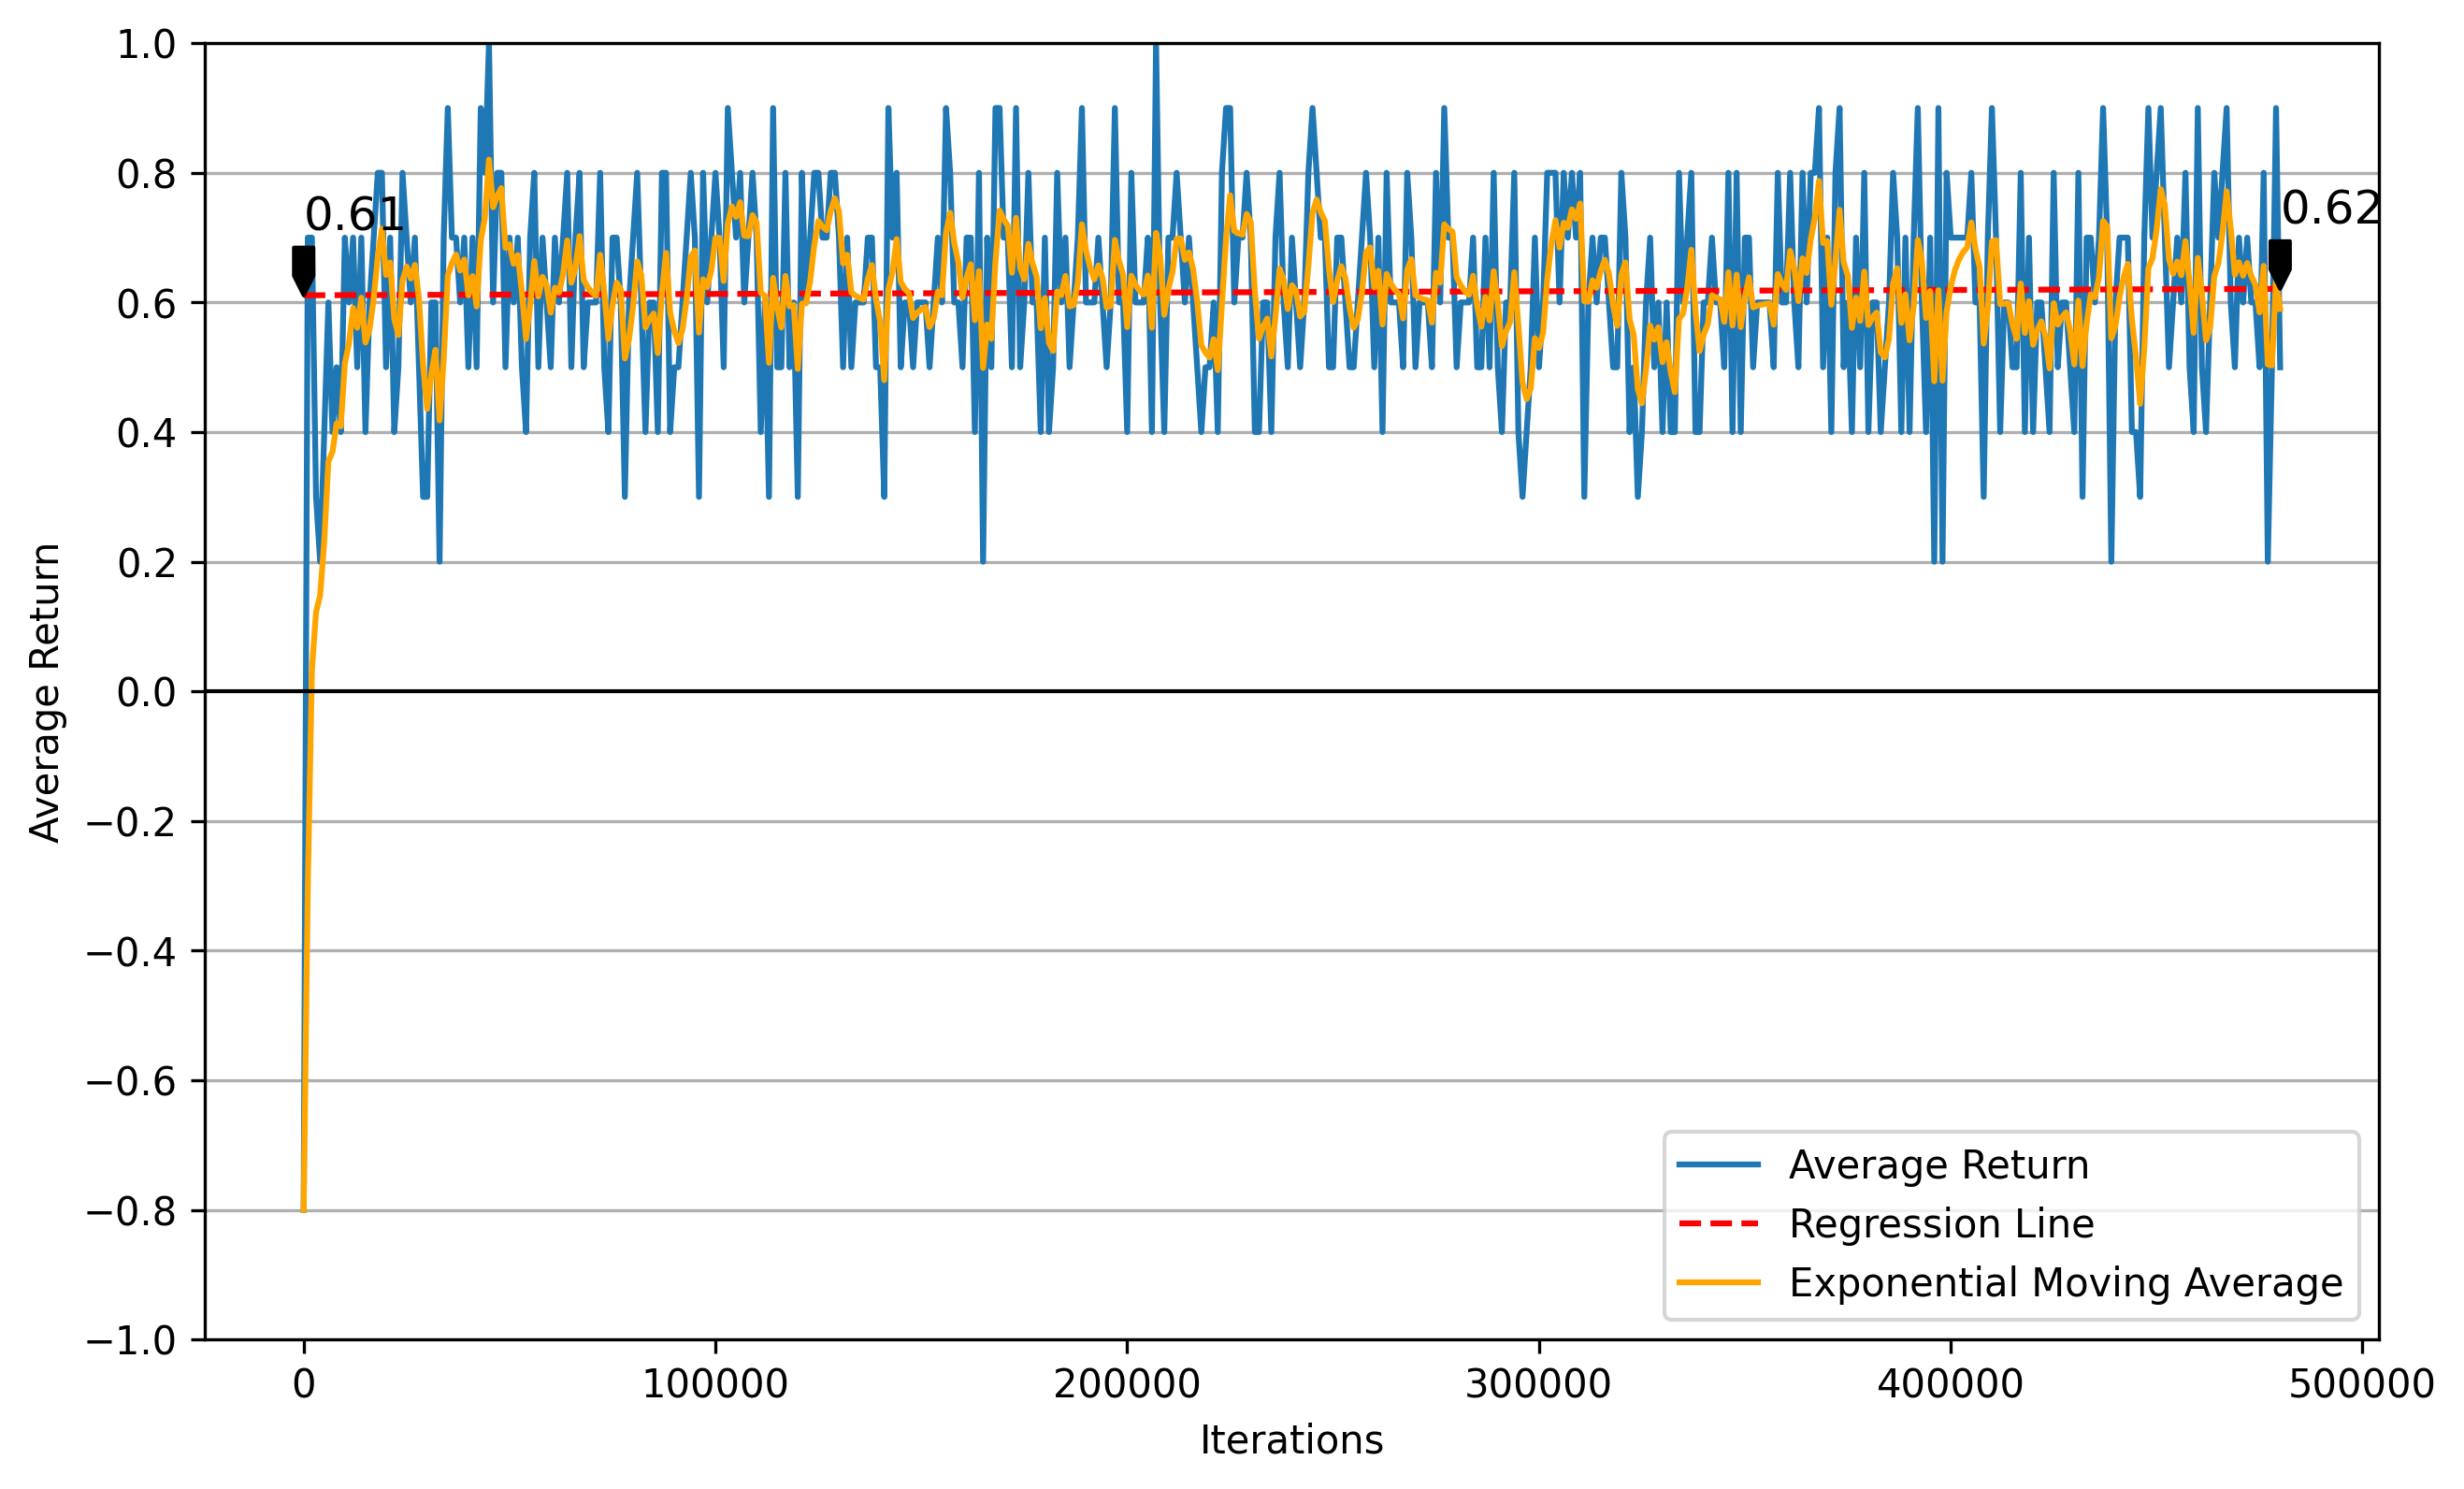

In [187]:
file_path = f"/tf/plots/DRL_V2_{current_time}.png"

iterations = range(0, num_iterations + 1, eval_interval)
regression = np.poly1d(np.polyfit(iterations, returns, 1))(iterations)

# Exponentiell gewichteter gleitender Durchschnitt berechnen
window_size = 5
alpha = 2 / (window_size + 1)
exp_moving_avg = np.zeros_like(returns)
exp_moving_avg[0] = returns[0]
for i in range(1, len(returns)):
    exp_moving_avg[i] = alpha * returns[i] + (1 - alpha) * exp_moving_avg[i - 1]

# Plot erstellen
plt.figure(dpi=300, figsize=(10, 6))
plt.plot(iterations, returns, label='Average Return')
plt.plot(iterations, regression, label='Regression Line', linestyle='--', color='red')

# Erster und letzter Punkt der Regressionslinie markieren
first_point = (iterations[0], regression[0])
last_point = (iterations[-1], regression[-1])
plt.annotate(f'{first_point[1]:.2f}', xy=first_point, xytext=(first_point[0], first_point[1] + 0.1),
             arrowprops=dict(facecolor='black', shrink=5, width=5, headwidth=5, headlength=5), fontsize=12)
plt.annotate(f'{last_point[1]:.2f}', xy=last_point, xytext=(last_point[0], last_point[1] + 0.1),
             arrowprops=dict(facecolor='black', shrink=5, width=5, headwidth=5, headlength=5), fontsize=12)

# Exponentiell gewichteter gleitender Durchschnitt hinzufügen
plt.plot(iterations, exp_moving_avg, label='Exponential Moving Average', linestyle='-', color='orange')

# Achsen beschriften und weitere Anpassungen
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1.2, 0.2))
plt.grid(True, which='major', axis='y')
plt.axhline(y=0, color='black', linewidth=1)
plt.legend()
plt.savefig(file_path)
plt.show()



## Lizenz

```txt
   Copyright 2023 The TF-Agents Authors.

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```